# Testing proposed analysis of structure factor $S(q)$

This notebook provides a proof of concept and tutorial of how the oscillatory behavior of the static structure factor post-quench is analyzed without the need for non-linear fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import defaultdict
import pickle

import dgutils.colors as colortools

plt.style.use('../include/notebook.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

π = np.pi

## We assume the functional form:

\begin{equation}
f(t) = \alpha + \beta \cos(\gamma t) + \delta t
\end{equation}

and we aim to extract all parameters $\alpha,\beta,\gamma,\delta$ from a simple analysis of the function (i.e. no fitting).  

### 1. Define the function and plot

In [2]:
def f(t,α,β,γ,δ):
    return α + β*np.cos(γ*t) + δ*t

Text(0, 0.5, '$f(t)$')

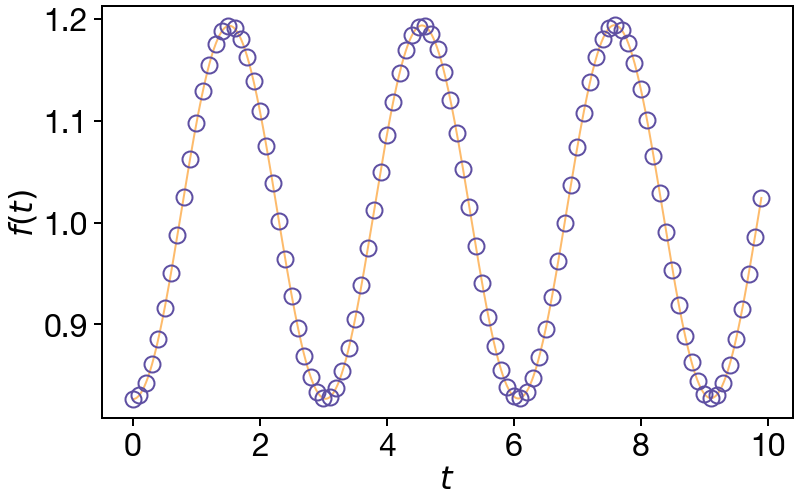

In [3]:
from scipy.interpolate import interp1d
α,β,γ,δ = 1+1E-2, 0.5*(1/1.2-1.2),2.07,1E-4

t_raw = np.arange(0,10,0.1)
_f_raw = f(t_raw,α,β,γ,δ)

f_spline = interp1d(t_raw, _f_raw, kind='cubic')
t_spline = np.arange(0,t_raw[-1],0.0001)

_f_spline = f_spline(t_spline)

plt.plot(t_spline,_f_spline,'-', color=colors[-4], lw=1)
plt.plot(t_raw,_f_raw,'o', mfc='None')
plt.xlabel(r'$t$')
plt.ylabel(r'$f(t)$')

### Decide whether we analyze the raw data or the spline fit

In [4]:
spline = True
if spline:
    t = t_spline
    _f = _f_spline
else:
    t = t_raw
    _f = _f_raw

## 2. Extract the period by looking at extrema

We also check that this works by plotting

Text(0, 0.5, '$f(t)$')

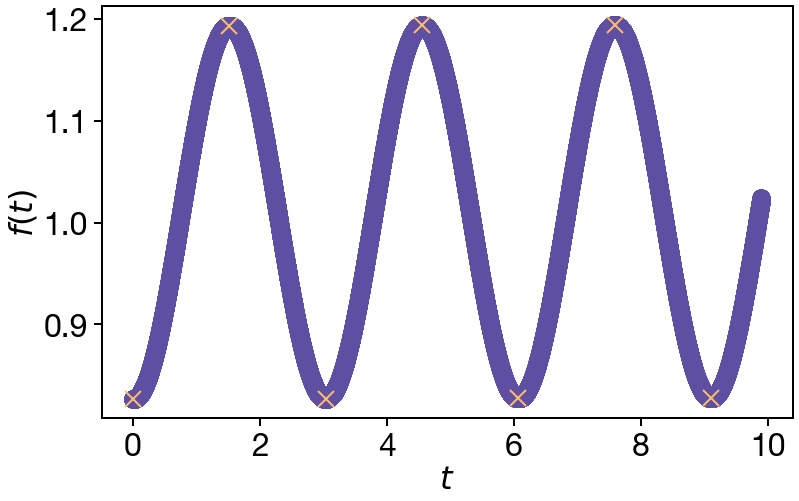

In [5]:
from scipy.signal import argrelextrema
max_idx = argrelextrema(_f_spline[10:], np.greater)[0]
min_idx = argrelextrema(_f_spline[10:], np.less)[0]
t_idx = np.zeros(1,dtype='int')
t_idx = np.append(t_idx,max_idx)
t_idx = np.append(t_idx,min_idx)
t_idx = np.sort(t_idx)

plt.plot(t_spline,_f_spline,'o', mfc='None')
plt.plot(t_spline[t_idx],_f_spline[t_idx], 'x', color=colors[-4])

plt.xlabel(r'$t$')
plt.ylabel(r'$f(t)$')

## 3. Extract the period

We extract using the first and second extrema
Compare with the actual one.

In [6]:
γ_ext = [π/t[t_idx[1]],2*π/t[t_idx[2]]]

γ̄_ext = np.average(γ_ext)
print(f'γ_ext = {γ_ext}\n')
print(f'γ̄_ext = {γ̄_ext:.3f},\n γ_gt = {γ:.3f}')

γ_ext = [2.0711976882844096, 2.0707881178497085]

γ̄_ext = 2.071,
 γ_gt = 2.070


### 4. Integrate up to 1/2, 1 and 3/2 periods

\begin{equation}
I_{n} = \frac{\gamma}{2n\pi} \int_0^{2n\pi/\gamma} f(t).
\end{equation}

In [7]:
from scipy import integrate
I = []
for j in range(1,4):
    Δt = (j/2)*2*π/γ̄_ext
    Δt = t[t_idx[j]]
    I.append(integrate.simps(_f[:t_idx[j]+1],t[:t_idx[j]+1])/Δt)
    
print(f'I = {I}')

I = [1.009969444033466, 1.010221346531876, 1.0101939605338615]


## 5. Compute the drift $\delta$ from these values

\begin{align}
\delta &= \frac{2\gamma}{\pi}(I_1 - I_{1/2}) \\
&= \frac{2\gamma}{\pi}(I_{3/2}-I_1) \\
&= \frac{\gamma}{\pi}(I_{3/2}-I_{1/2})\,.
\end{align}

In [8]:
δ_ext = [None]*3
δ_ext[0] = (2*γ̄_ext/π)*(I[1]-I[0])
δ_ext[1] = (2*γ̄_ext/π)*(I[2]-I[1])
δ_ext[2] = (γ̄_ext/π)*(I[2]-I[0])
print(f'δ_ext = {δ_ext}\n')

δ̄_ext = np.average(δ_ext)
print(f'δ̄_ext = {δ̄_ext}\n δ_gt = {δ}')

δ_ext = [0.0003321170781806277, -3.610665912813717e-05, 0.00014800520952624527]

δ̄_ext = 0.00014800520952624527
 δ_gt = 0.0001


## 6. Compute the average $\alpha$ from these values

\begin{align}
\alpha &= 2I_{1/2} - I_1 \\
&= \frac{1}{2}(3I_{1/2} - I_{3/2}) \\
&= 3I_1 - 2I_{3/2}.
\end{align}

In [9]:
α_ext = [None]*3 
α_ext[0] = 2*I[0] - I[1]
α_ext[1] = 0.5*(3*I[0] - I[2])
α_ext[2] = 3*I[1]-2*I[2]
print(f'α_ext = {α_ext}\n')

ᾱ_ext = np.average(α_ext)
print(f'ᾱ_ext = {ᾱ_ext}\n α_gt = {α}')

α_ext = [1.0097175415350559, 1.009857185783268, 1.010276118527905]

ᾱ_ext = 1.0099502819487431
 α_gt = 1.01
